# Python Configuration

In [1]:
# python version:
from platform import python_version
print(f"python version = {python_version()}")

# We used the following version:
# python version = 3.8.6

python version = 3.8.6


In [2]:
# python standard library packages:
import importlib

# import more packages:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# import own package:
import functions as my

# the following package is only needed to view data interactively,
# otherwise you can comment the import out:
import qgrid  # https://github.com/quantopian/qgrid

In [3]:
# package versions:
print(f"numpy      version = {np.__version__}")
print(f"pandas     version = {pd.__version__}")
print(f"matplotlib version = {matplotlib.__version__}")

# the following package is only needed to view data interactively,
# otherwise you can comment this out:
print(f"qgrid      version = {qgrid.__version__}")

# We used the following versions:
# numpy      version = 1.19.2
# pandas     version = 1.1.3
# matplotlib version = 3.3.2
# qgrid      version = 1.3.1

numpy      version = 1.19.2
pandas     version = 1.1.3
matplotlib version = 3.3.2
qgrid      version = 1.3.1


# Raw Data Source

- **Source:** [Photovoltaic Geographical Information System (PVGIS)](https://ec.europa.eu/jrc/en/pvgis): [tool](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html), [users manual](https://ec.europa.eu/jrc/en/PVGIS/docs/usermanual), [hourly-radiation](https://ec.europa.eu/jrc/en/PVGIS/tools/hourly-radiation)

- **Download** the the csv-file `Timeseries_50.000_10.000_SA_1kWp_crystSi_14_37deg_-4deg_2016_2016.csv` using the [PVGIS tool](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html) with the following location and settings:

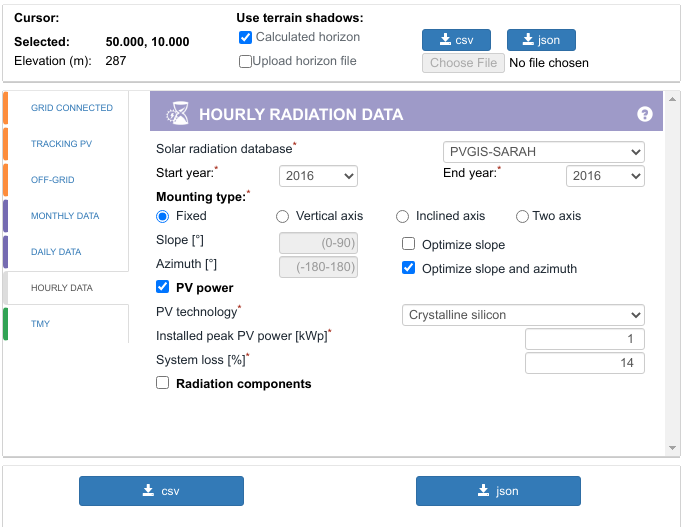

- time frame: up to and including 2016
- sampling interval: 1 hour
- units: W
- location: Konstanz, Germany

- **[legal notice](https://ec.europa.eu/info/legal-notice_en):** "[...] reuse is allowed, provided appropriate credit is given and changes are indicated."

# Loading Raw Data

In [4]:
# path to download directory:
my_path = "../data/pv/raw/"

The legend at the end of the original csv file says:

```
P: PV system power (W)
G(i): Global irradiance on the inclined plane (plane of the array) (W/m2)
H_sun: Sun height (degree)
T2m: 2-m air temperature (degree Celsius)
WS10m: 10-m total wind speed (m/s)
Int: 1 means solar radiation values are reconstructed
PVGIS (c) European Communities, 2001-2020
```

1. **Remove the legend at the end of the original csv file.**
2. **Save the new file as:**

In [5]:
my_file = "Timeseries_50.000_10.000_SA_1kWp_crystSi_14_37deg_-4deg_2016_2016_no_legend.csv"

In [6]:
# parse into a pandas data frame:

# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
my_parser = lambda date: pd.to_datetime(date, format='%Y%m%d:%H%M')

my_df = pd.read_csv(my_path + my_file, 
                    index_col=0, 
                    skiprows=10, 
                    parse_dates=True, 
                    date_parser=my_parser)

In [7]:
my_df.head(3)

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
2016-01-01 00:10:00,0.0,0.0,0.0,1.31,1.70,0.0
2016-01-01 01:10:00,0.0,0.0,0.0,1.42,1.66,0.0
2016-01-01 02:10:00,0.0,0.0,0.0,1.53,1.63,0.0


In [8]:
my_df.tail(3)

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
2016-12-31 21:10:00,0.0,0.0,0.0,-4.55,2.62,0.0
2016-12-31 22:10:00,0.0,0.0,0.0,-4.55,2.62,0.0
2016-12-31 23:10:00,0.0,0.0,0.0,-4.55,2.62,0.0


# Processing of Raw Data

## Checks

In [9]:
# importlib.reload(my);
my.checks(my_df, my_year='2016')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK


In [10]:
# check time changes in 2016 by visual inspection:
# qgrid.show_grid(my_df.loc['2016-03-27'])
# qgrid.show_grid(my_df.loc['2016-10-30'])

## Changes

In [11]:
# rescale power to kW:

my_df['PV_kW'] = my_df['P']/1000
my_df.columns

Index(['P', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int', 'PV_kW'], dtype='object')

,P,G(i),H_sun,T2m,WS10m,Int,PV_kW
time,,,,,,,
2016-07-01 12:00:00,443.2100,558.5100,61.5700,23.70,5.8100,0.0,0.443210
2016-07-01 12:15:00,491.6975,619.8575,60.1575,23.67,5.7975,0.0,0.491698
2016-07-01 12:30:00,540.1850,681.2050,58.7450,23.64,5.7850,0.0,0.540185
2016-07-01 12:45:00,588.6725,742.5525,57.3325,23.61,5.7725,0.0,0.588672
2016-07-01 13:00:00,637.1600,803.9000,55.9200,23.58,5.7600,0.0,0.637160


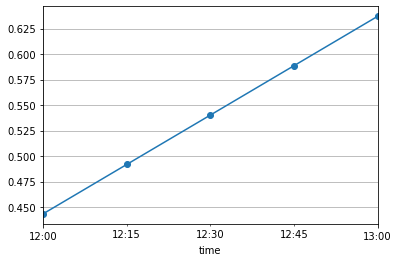

In [12]:
# resample to dt = 0.25 h using linear interpolation:

my_df = my_df.resample(rule='15Min').mean().interpolate(method='linear')

# check: 
my_df.loc['2016-07-01 12:00':'2016-07-01 13:00','PV_kW'].plot(marker='o')
plt.grid(True)
my_df.loc['2016-07-01 12:00':'2016-07-01 13:00',]

In [13]:
# exptrapolate December 31 23:00:

add_df = pd.DataFrame(0.0, columns=['PV_kW'], 
                      index = pd.date_range(
                      start='2016-12-31 23:15:00', 
                      end  ='2016-12-31 23:45:00', freq='15Min') 
                     )
my_df = my_df.append(add_df)

# check:
my_df.tail(4)

,P,G(i),H_sun,T2m,WS10m,Int,PV_kW
2016-12-31 23:00:00,0.0,0.0,0.0,-4.55,2.62,0.0,0.0
2016-12-31 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-12-31 23:45:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [14]:
# delete unneeded columns:

my_df.drop(['P', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int'], axis=1, inplace=True)

In [15]:
# annual energy generations:
dt = 0.25
print(f"energy generation in 2016: {my_df['PV_kW'].sum()*dt:.2f} kWh")

energy generation in 2016: 1047.16 kWh


In [16]:
# qgrid.show_grid(my_df)

In [17]:
my_df.head(3)

,PV_kW
2016-01-01 00:00:00,0.0
2016-01-01 00:15:00,0.0
2016-01-01 00:30:00,0.0


In [18]:
my_df.tail(3)

,PV_kW
2016-12-31 23:15:00,0.0
2016-12-31 23:30:00,0.0
2016-12-31 23:45:00,0.0


## Checks

In [19]:
# importlib.reload(my);
my.checks(my_df, my_year='2016')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
- check for set of timestamps    : OK


## Predictions

### Example and Function

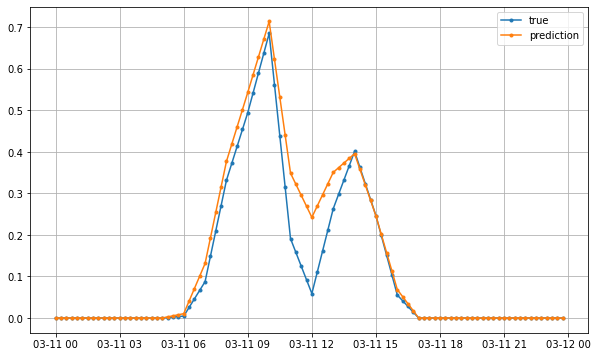

In [20]:
# predictions: function and example of 1 day prediction

my_day_str = "2016-03-11"

my_format ="%Y-%m-%d"
my_day_ts = pd.to_datetime(my_day_str, format=my_format)

def my_predict_pv(df, day_ts, p=0.75):
    """
    computes a weighted sum:
    p is the weight of the values of the prediction day day_ts
    (1 - p) is the weight of the values of the day before
    """
    my_one_day_before_ts = day_ts - pd.Timedelta(1, unit='days')
    my_prediction = my_df.loc[my_one_day_before_ts.strftime(my_format),'PV_kW'].values
    my_prediction = (1 - p)*my_prediction + \
                    p*my_df.loc[my_day_ts.strftime(my_format),'PV_kW'].values
    return my_prediction

my_prediction = my_predict_pv(my_df, my_day_ts)

# display:
plt.figure(figsize=(10,6))
my_times = my_df.loc[my_day_str,'PV_kW'].index
my_true_values = my_df.loc[my_day_str,'PV_kW'].values
plt.plot(my_times, my_true_values, '.-', label='true')
plt.plot(my_times, my_prediction, '.-', label='prediction')
plt.legend()
plt.grid()

### Add Predictions

In [21]:
my_df['PV_kW_pred'] = np.NaN*my_df['PV_kW']
for my_day_ts in pd.date_range(start='2016-01-02', end='2016-12-31'):
    my_prediction = my_predict_pv(my_df, my_day_ts)
    my_df.loc[my_day_ts.strftime(my_format),'PV_kW_pred'] = my_prediction

In [22]:
# first day in year: use day after for convex mixing
p=0.75
my_prediction = my_df.loc['2016-01-02','PV_kW'].values
my_prediction = (1 - p)*my_prediction + \
                p*my_df.loc['2016-01-01','PV_kW'].values
my_df.loc['2016-01-01','PV_kW_pred'] = my_prediction

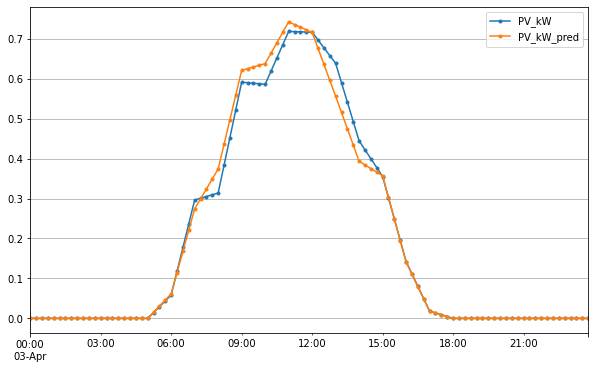

In [23]:
my_df.loc['2016-4-03'].plot(figsize=(10,6), grid=True, marker='.');

# Export of Processed Data

In [24]:
# export to pickle:
my_df.to_pickle('../data/pv/processed/pv_df.pickle')

if 0: # export to csv:
    my_df.to_csv('../data/pv/processed/pv_df.csv')

# Some Analyses

In [25]:
# import pickle:
my_df = pd.read_pickle('../data/pv/processed/pv_df.pickle')

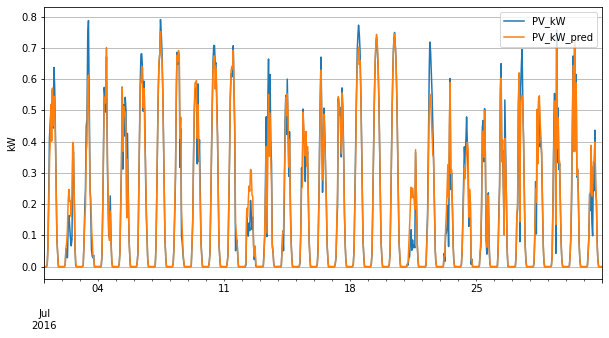

In [26]:
# plot of a sample day and its prediction:

my_df.loc['2016-07-01':'2016-07-31',].plot(figsize=(10,5))
plt.ylabel('kW')
plt.grid(True)

In [27]:
# statistics of prediction errors of non-zero powers:

my_ind = my_df['PV_kW'] != 0 
my_df_nzP = my_df.loc[my_ind, 'PV_kW'] - \
            my_df.loc[my_ind, 'PV_kW_pred']

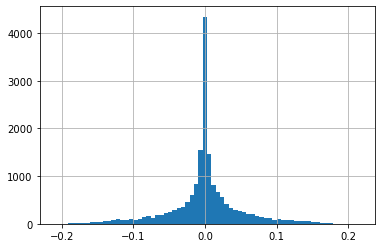

In [28]:
my_df_nzP.hist(bins=70);

In [29]:
print(" prediction error of non-zero powers:")
print(f"    mean = {my_df_nzP.mean():.5f} kW")
print(f"    std  = {my_df_nzP.std():.5f} kW")

 prediction error of non-zero powers:
    mean = 0.00003 kW
    std  = 0.04883 kW
